In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import dot, multiply, diag, power
from numpy import pi, exp, sin, cos
from numpy.linalg import inv, eig, pinv, solve
from scipy.linalg import svd, svdvals
from math import floor, ceil # python 3.x

In [157]:
def dmd(X, Y, truncate=None):
    '''
    version created by Robert Taylor
    for more info: https://humaticlabs.com/blog/dmd-python/

    in this funciton, truncate == r
    '''
    if truncate == 0:
        # return empty vectors
        mu = np.array([], dtype='complex')
        Phi = np.zeros([X.shape[0], 0], dtype='complex')
    else:
        U2,Sig2,Vh2 = svd(X, False) # SVD of input matrix
        r = len(Sig2) if truncate is None else truncate # rank truncation
        U = U2[:,:r]
        Sig = diag(Sig2)[:r,:r]
        V = Vh2.conj().T[:,:r]
        Atil = dot(dot(dot(U.conj().T, Y), V), inv(Sig)) # build A tilde
        mu,W = eig(Atil)
        Phi = dot(dot(dot(Y, V), inv(Sig)), W) # build DMD modes
    return mu, Phi

def svht(X, sv=None):
    # svht for sigma unknown
    m,n = sorted(X.shape) # ensures m <= n
    beta = m / n # ratio between 0 and 1
    if sv is None:
        sv = svdvals(X)
    sv = np.squeeze(sv)
    omega_approx = 0.56 * beta**3 - 0.95 * beta**2 + 1.82 * beta + 1.43
    return np.median(sv) * omega_approx

def mrdmd(D, level=0, bin_num=0, offset=0, max_levels=20, max_cycles=2, do_svht=True):
    """
    Compute the multi-resolution DMD on the dataset `D`, returning a list of nodes
    in the hierarchy. Each node represents a particular "time bin" (window in time) at
    a particular "level" of the recursion (time scale). The node is an object consisting
    of the various data structures generated by the DMD at its corresponding level and
    time bin. The `level`, `bin_num`, and `offset` parameters are for record keeping 
    during the recursion and should not be modified unless you know what you are doing.
    The `max_levels` parameter controls the maximum number of levels. The `max_cycles`
    parameter controls the maximum number of mode oscillations in any given time scale 
    that qualify as "slow". The `do_svht` parameter indicates whether or not to perform
    optimal singular value hard thresholding.

    More info here: https://humaticlabs.com/blog/mrdmd-python/
    """

    # 4 times nyquist limit to capture cycles
    nyq = 8 * max_cycles

    # time bin size
    bin_size = D.shape[1]
    if bin_size < nyq:
        return []

    # extract subsamples 
    step = floor(bin_size / nyq) # max step size to capture cycles
    _D = D[:,::step]
    X = _D[:,:-1]
    Y = _D[:,1:]

    # determine rank-reduction
    if do_svht:
        _sv = svdvals(_D)
        tau = svht(_D, sv=_sv)
        r = sum(_sv > tau)
    else:
        r = min(X.shape)

    # compute dmd
    mu,Phi = dmd(X, Y, r)

    # frequency cutoff (oscillations per timestep)
    rho = max_cycles / bin_size

    # consolidate slow eigenvalues (as boolean mask)
    slow = (np.abs(np.log(mu) / (2 * pi * step))) <= rho
    n = sum(slow) # number of slow modes

    # extract slow modes (perhaps empty)
    mu = mu[slow]
    Phi = Phi[:,slow]

    if n > 0:

        # vars for the objective function for D (before subsampling)
        Vand = np.vander(power(mu, 1/step), bin_size, True)
        P = multiply(dot(Phi.conj().T, Phi), np.conj(dot(Vand, Vand.conj().T)))
        q = np.conj(diag(dot(dot(Vand, D.conj().T), Phi)))

        # find optimal b solution
        b_opt = solve(P, q).squeeze()

        # time evolution
        Psi = (Vand.T * b_opt).T

    else:

        # zero time evolution
        b_opt = np.array([], dtype='complex')
        Psi = np.zeros([0, bin_size], dtype='complex')

    # dmd reconstruction
    D_dmd = dot(Phi, Psi)   

    # remove influence of slow modes
    D = D - D_dmd

    # record keeping
    node = type('Node', (object,), {})()
    node.level = level            # level of recursion
    node.bin_num = bin_num        # time bin number
    node.bin_size = bin_size      # time bin size
    node.start = offset           # starting index
    node.stop = offset + bin_size # stopping index
    node.step = step              # step size
    node.rho = rho                # frequency cutoff
    node.r = r                    # rank-reduction
    node.n = n                    # number of extracted modes
    node.mu = mu                  # extracted eigenvalues
    node.Phi = Phi                # extracted DMD modes
    node.Psi = Psi                # extracted time evolution
    node.b_opt = b_opt            # extracted optimal b vector
    nodes = [node]

    # split data into two and do recursion
    if level < max_levels:
        split = ceil(bin_size / 2) # where to split
        nodes += mrdmd(
            D[:,:split],
            level=level+1,
            bin_num=2*bin_num,
            offset=offset,
            max_levels=max_levels,
            max_cycles=max_cycles,
            do_svht=do_svht
            )
        nodes += mrdmd(
            D[:,split:],
            level=level+1,
            bin_num=2*bin_num+1,
            offset=offset+split,
            max_levels=max_levels,
            max_cycles=max_cycles,
            do_svht=do_svht
            )

    return nodes

def stitch(nodes, level):
    
    # get length of time dimension
    start = min([nd.start for nd in nodes])
    stop = max([nd.stop for nd in nodes])
    t = stop - start

    # extract relevant nodes
    nodes = [n for n in nodes if n.level == level]
    nodes = sorted(nodes, key=lambda n: n.bin_num)
    
    # stack DMD modes
    Phi = np.hstack([n.Phi for n in nodes])
    
    # allocate zero matrix for time evolution
    nmodes = sum([n.n for n in nodes])
    Psi = np.zeros([nmodes, t], dtype='complex')
    
    # copy over time evolution for each time bin
    i = 0
    for n in nodes:
        _nmodes = n.Psi.shape[0]
        Psi[i:i+_nmodes,n.start:n.stop] = n.Psi
        i += _nmodes
    
    return Phi,Psi

def mr_recon(D):
    nodes = mrdmd(D)
    
    Phi0,Psi0 = stitch(nodes, 0)
    Phi1,Psi1 = stitch(nodes, 1)
    Phi2,Psi2 = stitch(nodes, 2)
    
    levels = sorted({nd.level for nd in nodes})
    D_hat_full = sum(stitch(nodes, l)[0] @ stitch(nodes, l)[1] for l in levels)
    
    D_iter = None
    for l in levels:
        fig, axes = plt.subplots(1,2, figsize=(15,5))
        ax = axes[1]
        _d = stitch(nodes, l)[0] @ stitch(nodes, l)[1]
        sns.heatmap(_d.real, cbar=False, square=True, ax=ax)
        ax.set_axis_off()
        
        if D_iter is None:
            D_iter = _d.real
        else:
            D_iter = D_iter + _d.real
            
        ax = axes[0]
        sns.heatmap(D_iter, cbar=False, square=True, ax=ax)
        ax.set_axis_off()
        plt.show()
        
    return nodes

def plot_eigs(nodes, levels, combined=False):
    p = np.linspace(0, 2*np.pi, 100)
    
    if combined:
        # all on one plot
        fix,ax = plt.subplots(1,1)
        ax.plot(np.cos(p), np.sin(p), c="k")
        
        for l in levels:
            ns = [n for n in nodes if n.level == l]
            eigs = []
            for n in ns:
                eigs.extend(n.mu)
            eigs = np.array(eigs)
            ax.scatter(eigs.real, eigs.imag, alpha=0.25, label=l)
        
        ax.set_aspect("equal")
        ax.set_title('wrt unit circle')
        ax.legend()
        ax.set_xlim(left = 0)
        
        ax.set_xlabel('Re'); ax.set_ylabel('Im')
    else:
        fix,axes = plt.subplots(1,len(levels), sharey=True)
        # plot unit circle
        for idx,l in enumerate(levels):
            ax = axes[idx]
            ax.plot(np.cos(p), np.sin(p), c="k")
            
            ns = [n for n in nodes if n.level == l]
            eigs = []
            for n in ns:
                eigs.extend(n.mu)
            eigs = np.array(eigs)
            ax.scatter(eigs.real, eigs.imag, alpha=.5, c='red', label=l)
        
            ax.set_aspect("equal")
            ax.set_xlim(left = 0, right=1.2)
            ax.set_title(f'level {l}')
            ax.set_axis_off()
    plt.show()
    
    

In [2]:
DATA_DIR = '../../datasets/NNN/'
dat = pd.read_pickle(os.path.join(DATA_DIR, ('face_roi_data.pkl')))
print(f'Unique face ROIs: {list(dat['roi'].unique())}')

Unique face ROIs: ['Unknown_19_F', 'MF1_9_F', 'MF1_8_F', 'AF3_18_F', 'MF1_7_F', 'Unknown_5_F', 'AMC3_28_F']


In [80]:
ROI = 'MF1_8_F' # Unknown_19_F
PVAL = 0.05

# load in per-image psth
sig = dat[dat['p_value'] < PVAL]
df = sig[sig['roi'] == ROI]
X = np.stack(df['img_psth'].to_numpy())
print(f'Loaded unit-level data for each image. Shape:', X.shape, '---> (units, time points, images)')

# center the data per unit and per image
X_centered = X - X.mean(axis=1, keepdims=True)
print('Centered shape:', X_centered.shape)

Loaded unit-level data for each image. Shape: (1409, 450, 1072) ---> (units, time points, images)
Centered shape: (1409, 450, 1072)






================================== all_faces ============================================ 


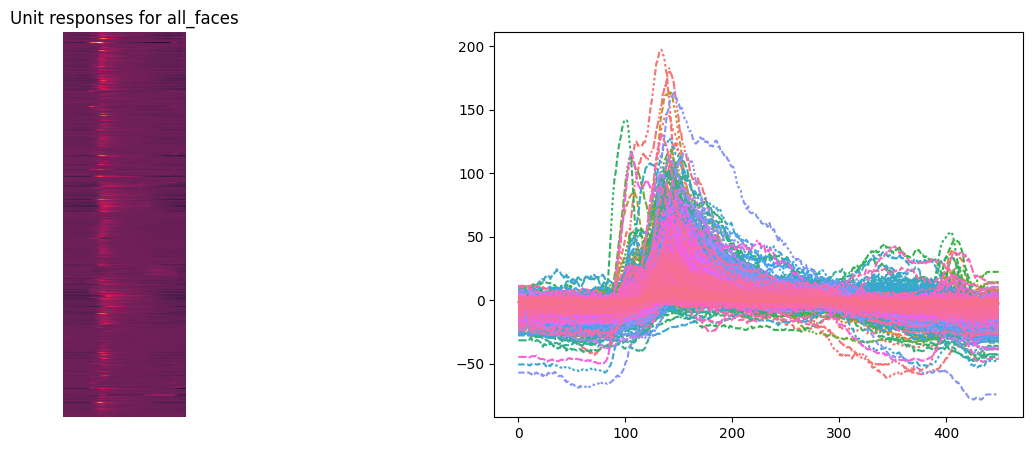

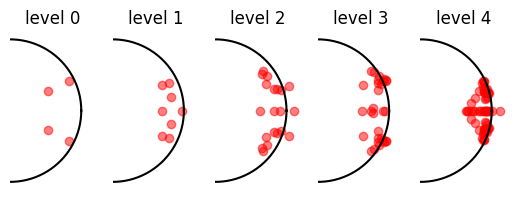

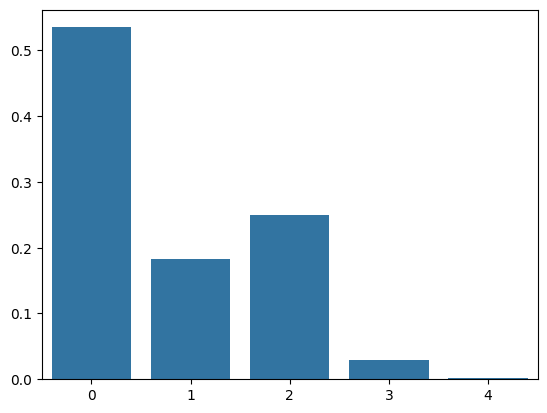

level 0  energy=0.54  band≈[0.000, 4.444] MHz
level 1  energy=0.18  band≈[4.444, 8.889] MHz
level 2  energy=0.25  band≈[8.889, 17.778] MHz
level 3  energy=0.03  band≈[17.778, 35.558] MHz
level 4  energy=0.00  band≈[35.558, 71.121] MHz




================================== all_bodies ============================================ 


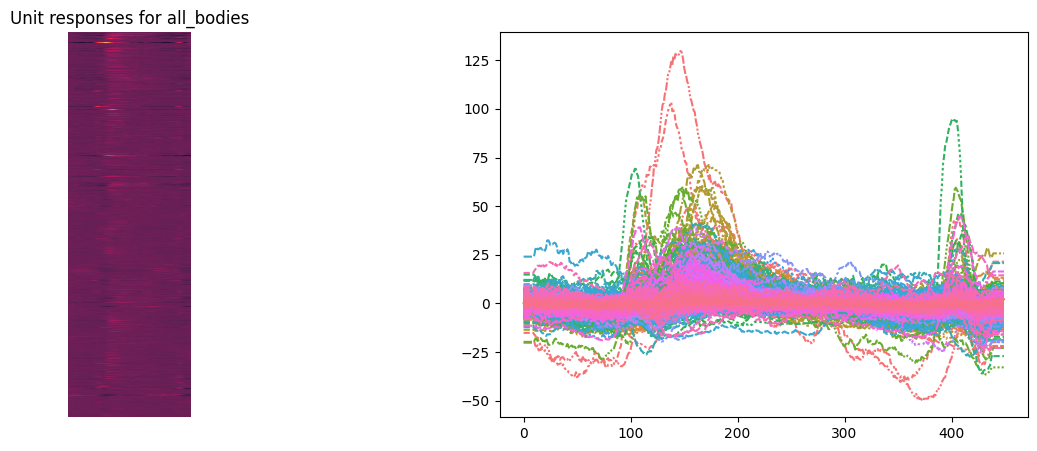

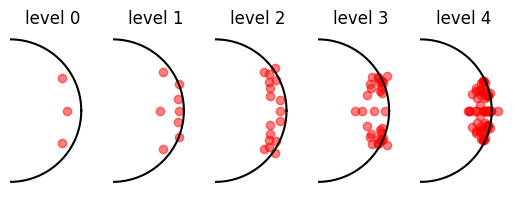

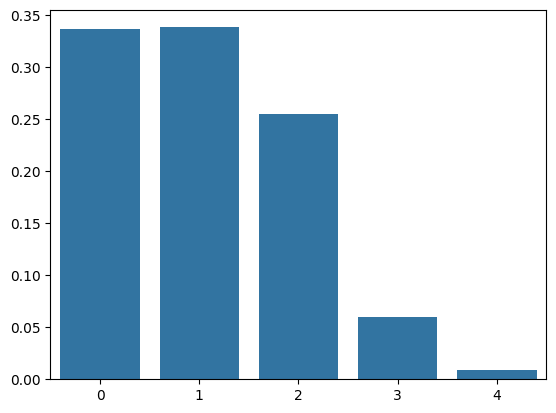

level 0  energy=0.34  band≈[0.000, 4.444] MHz
level 1  energy=0.34  band≈[4.444, 8.889] MHz
level 2  energy=0.26  band≈[8.889, 17.778] MHz
level 3  energy=0.06  band≈[17.778, 35.558] MHz
level 4  energy=0.01  band≈[35.558, 71.121] MHz




================================== all_objects ============================================ 


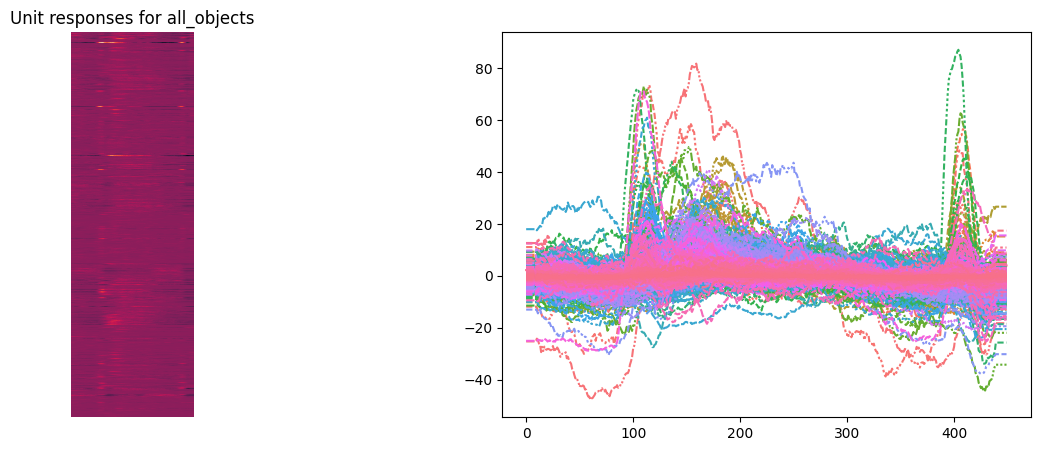

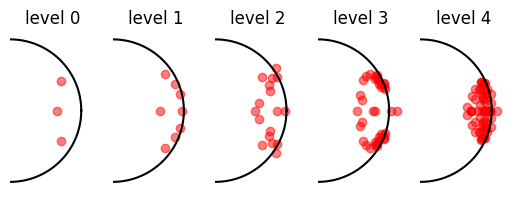

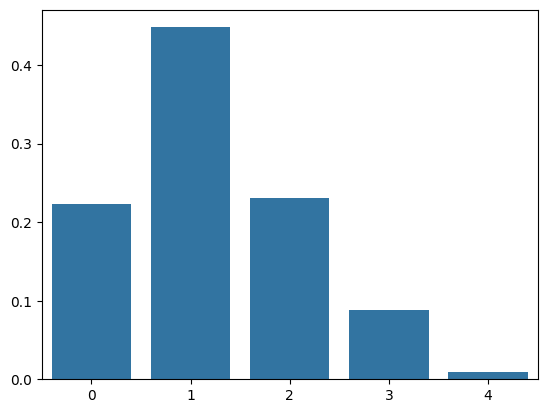

level 0  energy=0.22  band≈[0.000, 4.444] MHz
level 1  energy=0.45  band≈[4.444, 8.889] MHz
level 2  energy=0.23  band≈[8.889, 17.778] MHz
level 3  energy=0.09  band≈[17.778, 35.558] MHz
level 4  energy=0.01  band≈[35.558, 71.121] MHz


In [180]:
img_sets = {
    "all_faces":  np.arange(1000, 1024),
    "all_bodies": np.concatenate([
        np.arange(1025, 1031),
        np.arange(1042, 1048),
        np.arange(1049, 1061)
    ]),
    "all_objects": np.concatenate([
        np.arange(1024,1025),
        np.arange(1031, 1042),
        np.arange(1048,1049),
        np.arange(1061, 1072)
    ])
}

for k,v in img_sets.items():
    print('\n\n\n\n====================================================================================')
    print(f'================================== {k} ============================================ ')
    print('====================================================================================')
    
    X_cat = X_centered[:, :, v]
    X_cat = np.mean(X_cat, axis=2)

    fig,axes = plt.subplots(1,2, figsize=(15,5))
    ax = axes[0]
    sns.heatmap(X_cat, cbar=False, square=True, ax=ax)
    ax.set_title(f'Unit responses for {k}')
    ax.set_axis_off()

    ax = axes[1]
    sns.lineplot(X_cat.T)
    ax.get_legend().remove()
    plt.show()

    # nodes = mr_recon(X_cat)
    nodes = mrdmd(X_cat)
    levels = sorted({nd.level for nd in nodes})
    plot_eigs(nodes, levels)

    E_levels = []
    for level in levels:
        Phi_l, Psi_l = stitch(nodes, level)
        E_levels.append(np.linalg.norm(Phi_l @ Psi_l, 'fro')**2)
    E_levels = np.array(E_levels)
    E_levels /= E_levels.sum()  # fraction of total energy
    
    sns.barplot(E_levels)
    plt.show()
    
    levels = sorted({nd.level for nd in nodes})
    E, bands = [], []
    f_max = 0
    for l in levels:
        Phi, Psi = stitch(nodes, l)
        E.append(np.linalg.norm(Phi @ Psi, 'fro')**2)
        # approximate band (0 .. f_max for that level)
        bin_len = max(nd.bin_size for nd in nodes if nd.level == l)
        rho = np.mean([nd.rho for nd in nodes if nd.level == l])
        dt = 1
        f_min = f_max
        f_max = rho / dt * 1000  # since nd.rho = max_cycles / bin_size
        bands.append((f_min, f_max))
    E = np.array(E) / np.sum(E)
    
    for l,(lo,hi),e in zip(levels,bands,E):
        print(f"level {l}  energy={e:.2f}  band≈[{lo:.3f}, {hi:.3f}] MHz")

Xt and Yt shape: (261, 449) (261, 449)


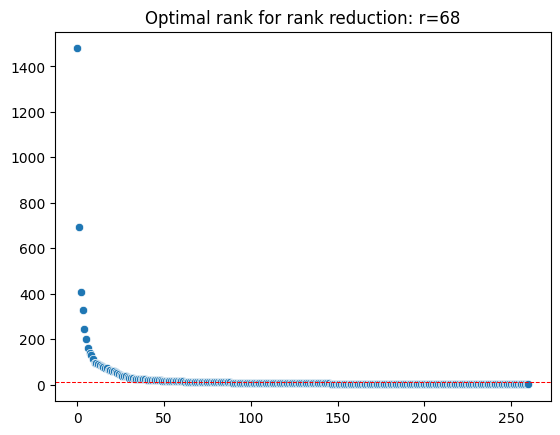

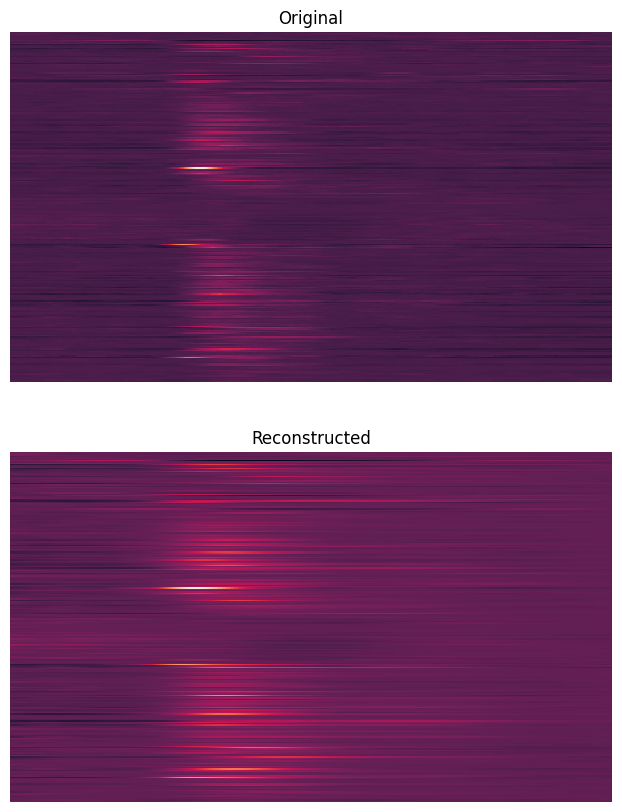

In [32]:
# NORMAL DMD on category level dynamics
Xi_ = X_cat[:, :-1]
Yi_ = X_cat[:,  1:]
print('Xt and Yt shape:', Xi_.shape, Yi_.shape)

# determine rank-reduction
sv = svdvals(Xi_)
tau = svht(Xi_, sv=sv)
r = sum(sv > tau)

fig,ax = plt.subplots(1,1)
sns.scatterplot(x=range(len(sv)), y=sv, ax=ax)
ax.axhline(tau, color='red', linestyle='dashed', linewidth=0.75)
ax.set_title(f'Optimal rank for rank reduction: r={r}')
plt.show()

t = np.arange(Xi_.shape[1])

# do dmd
mu,Phi = dmd(Xi_, Yi_, r)

# compute time evolution
b = dot(pinv(Phi), Xi_[:,0])
Vand = np.vander(mu, len(t), True)
Psi = (Vand.T * b).T


# 1) initial amplitudes (b): solve Phi @ b ≈ X[:,0]
b, *_ = np.linalg.lstsq(Phi, Xi_[:, 0], rcond=None)  # (r,)

# 2) time dynamics (Psi): Psi[k,t] = b[k] * mu[k]**t
Psi = (b[:, None]) * np.power(mu[:, None], t[None, :])  # shape (r, Trec)

# 3) reconstruction
Xhat = Phi @ Psi

Xhat = Xhat.real

fig,axes = plt.subplots(2,1, figsize=(12,10))
ax = axes[0]
sns.heatmap(Xi_[:, :450], label="data", cbar=False, square=True, ax=ax)
ax.set_axis_off()
ax.set_title('Original')

ax = axes[1]
sns.heatmap(Xhat[:, :450], label="DMD recon", cbar=False, square=True, ax=ax)
ax.set_axis_off()
ax.set_title('Reconstructed')
plt.show()

(261, 450)


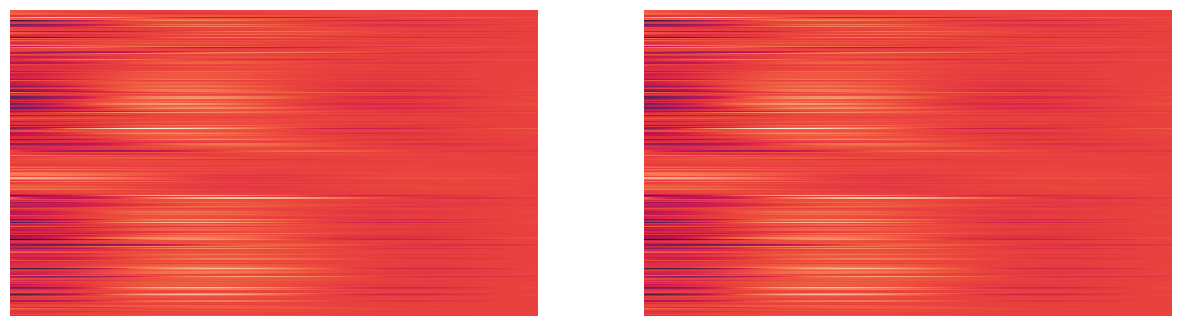

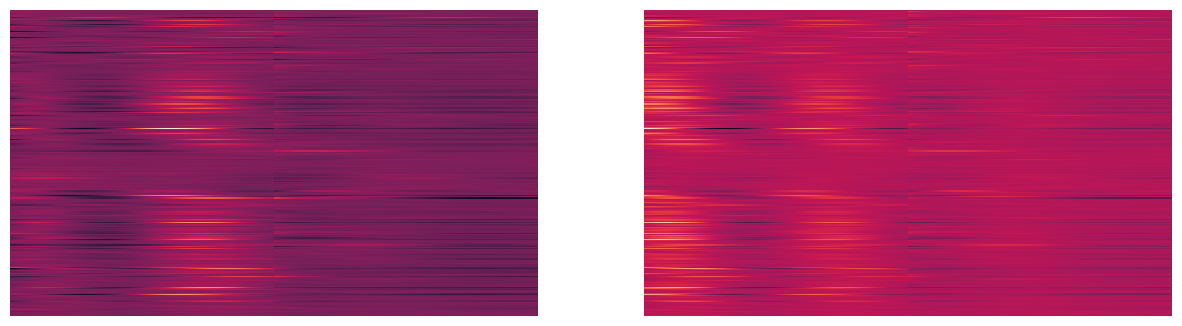

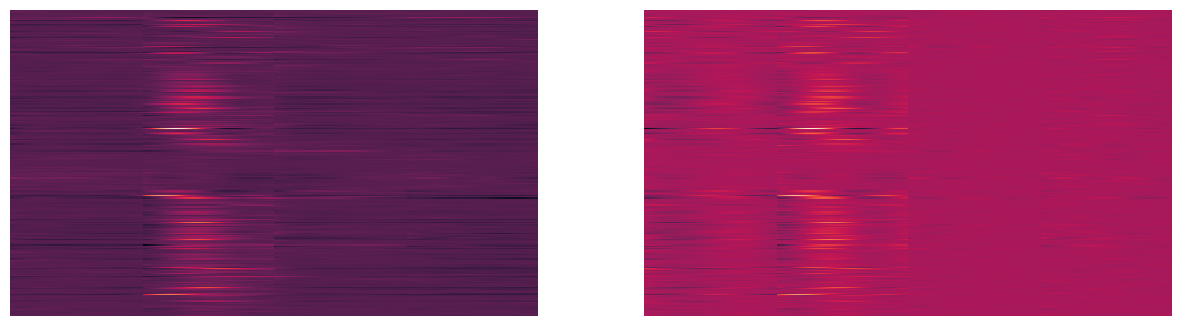

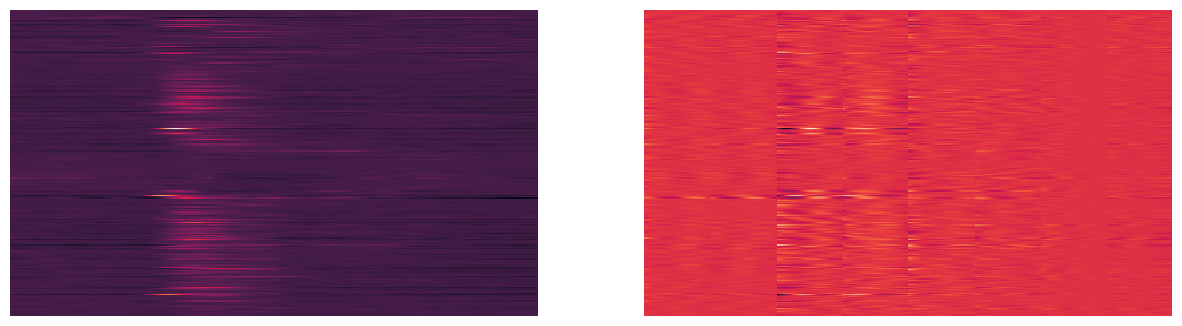

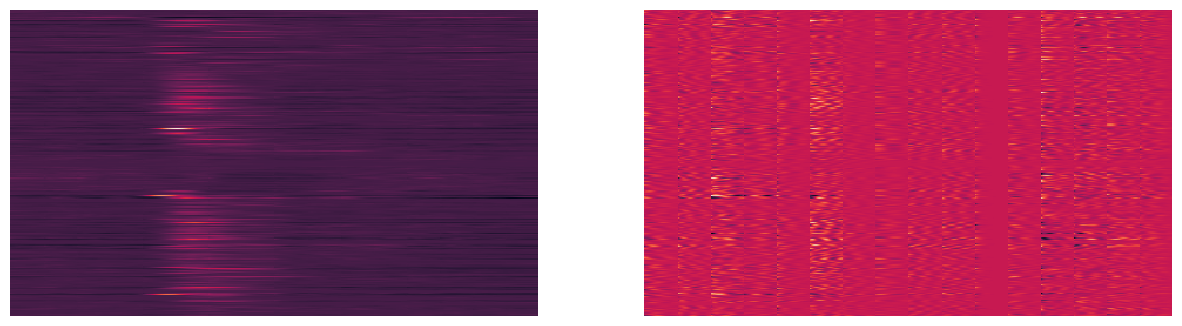

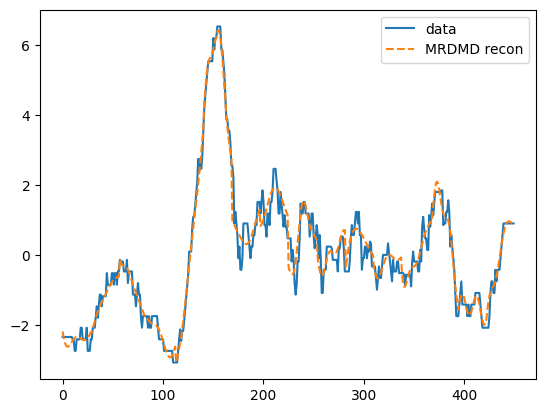

In [33]:
D = X_cat
print(D.shape)
nodes = mrdmd(D)

Phi0,Psi0 = stitch(nodes, 0)
Phi1,Psi1 = stitch(nodes, 1)
Phi2,Psi2 = stitch(nodes, 2)

levels = sorted({nd.level for nd in nodes})
D_hat_full = sum(stitch(nodes, l)[0] @ stitch(nodes, l)[1] for l in levels)

D_iter = None
for l in levels:
    fig, axes = plt.subplots(1,2, figsize=(15,5))
    ax = axes[1]
    _d = stitch(nodes, l)[0] @ stitch(nodes, l)[1]
    sns.heatmap(_d.real, cbar=False, square=True, ax=ax)
    ax.set_axis_off()
    
    if D_iter is None:
        D_iter = _d.real
    else:
        D_iter = D_iter + _d.real
        
    ax = axes[0]
    sns.heatmap(D_iter, cbar=False, square=True, ax=ax)
    ax.set_axis_off()
    plt.show()

i = 50
plt.plot(D[i], label='data')
plt.plot(D_hat_full[i].real, '--', label='MRDMD recon')
plt.legend(); plt.show()

Text(0, 0.5, 'Im')

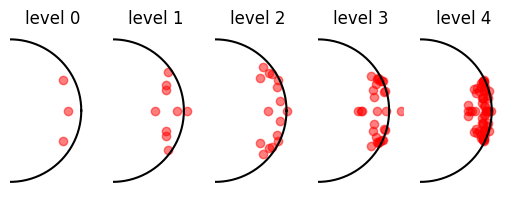

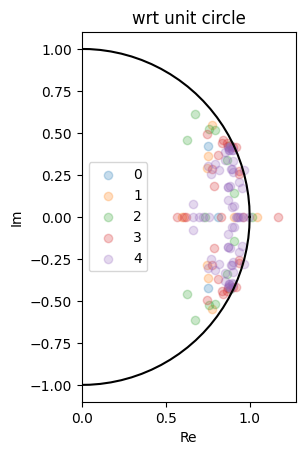

In [51]:
fix,axes = plt.subplots(1,len(levels), sharey=True)

# plot unit circle
p = np.linspace(0, 2*np.pi, 100)

for idx,l in enumerate(levels):
    ax = axes[idx]
    ax.plot(np.cos(p), np.sin(p), c="k")
    
    ns = [n for n in nodes if n.level == l]
    eigs = []
    for n in ns:
        eigs.extend(n.mu)
    eigs = np.array(eigs)
    ax.scatter(eigs.real, eigs.imag, alpha=.5, c='red', label=l)

    ax.set_aspect("equal")
    ax.set_xlim(left = 0, right=1.2)
    ax.set_title(f'level {l}')
    ax.set_axis_off()

# all on one plot
fix,ax = plt.subplots(1,1)

# plot unit circle
ax.plot(np.cos(p), np.sin(p), c="k")

for l in levels:
    ns = [n for n in nodes if n.level == l]
    eigs = []
    for n in ns:
        eigs.extend(n.mu)
    eigs = np.array(eigs)
    ax.scatter(eigs.real, eigs.imag, alpha=0.25, label=l)

ax.set_aspect("equal")
ax.set_title('wrt unit circle')
ax.legend()
ax.set_xlim(left = 0)

ax.set_xlabel('Re'); ax.set_ylabel('Im')

level 0  energy=0.07  band≈[0.000, 4.444] MHz
level 1  energy=0.38  band≈[4.444, 8.889] MHz
level 2  energy=0.37  band≈[8.889, 17.778] MHz
level 3  energy=0.16  band≈[17.778, 35.558] MHz
level 4  energy=0.03  band≈[35.558, 71.121] MHz


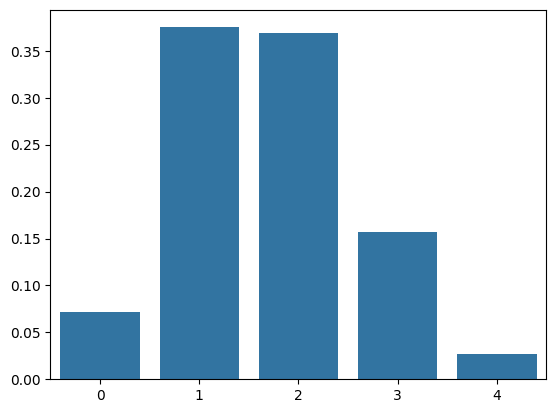

In [76]:
E_levels = []
for level in levels:
    Phi_l, Psi_l = stitch(nodes, level)
    E_levels.append(np.linalg.norm(Phi_l @ Psi_l, 'fro')**2)
E_levels = np.array(E_levels)
E_levels /= E_levels.sum()  # fraction of total energy

sns.barplot(E_levels)

levels = sorted({nd.level for nd in nodes})
E, bands = [], []
f_max = 0
for l in levels:
    Phi, Psi = stitch(nodes, l)
    E.append(np.linalg.norm(Phi @ Psi, 'fro')**2)
    # approximate band (0 .. f_max for that level)
    bin_len = max(nd.bin_size for nd in nodes if nd.level == l)
    rho = np.mean([nd.rho for nd in nodes if nd.level == l])
    dt = 1
    f_min = f_max
    f_max = rho / dt * 1000  # since nd.rho = max_cycles / bin_size
    bands.append((f_min, f_max))
E = np.array(E) / np.sum(E)

for l,(lo,hi),e in zip(levels,bands,E):
    print(f"level {l}  energy={e:.2f}  band≈[{lo:.3f}, {hi:.3f}] MHz")

/var/folders/nz/k0v468mj4w5_mx5nsmsgbwwc0000gq/T/ipykernel_87108/3530007490.py:78: RuntimeWarning: invalid value encountered in log
  slow = (np.abs(np.log(mu) / (2 * pi * step))) <= rho


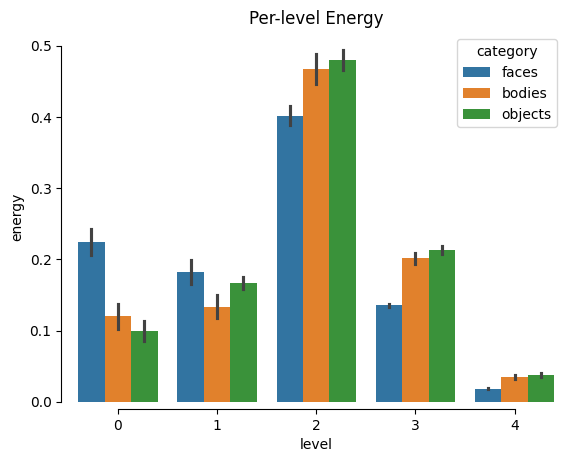

In [112]:
def level_energy(nodes):
    levs = sorted({n.level for n in nodes})
    E = []
    for ℓ in levs:
        Phi, Psi = stitch(nodes, ℓ)
        E.append(np.linalg.norm(Phi @ Psi, 'fro')**2)
    E = np.array(E); return E / E.sum()

category_E = {}
Edf = pd.DataFrame(columns=['level', 'energy', 'category'])
for k, v in img_sets.items():
    # energy matrix: images × levels
    E_cat = np.vstack([
        level_energy(mrdmd(X_centered[:, :, i], max_levels=5))
        for i in v
    ])
    category_E[k] = E_cat

    # store all values, one row per image × level
    for img_idx in range(E_cat.shape[0]):
        for level_idx in range(E_cat.shape[1]):
            Edf.loc[len(Edf)] = {
                'level': level_idx,
                'energy': E_cat[img_idx, level_idx],
                'category': k.split('_')[-1]
            }

fig,ax = plt.subplots(1,1)
sns.barplot(data=Edf, x='level', y='energy', hue='category', estimator = 'median', errorbar='se', ax=ax)
ax.set_title('Per-level Energy')
sns.despine(fig=fig, trim=True, offset=5)
plt.show()

/var/folders/nz/k0v468mj4w5_mx5nsmsgbwwc0000gq/T/ipykernel_87108/3530007490.py:78: RuntimeWarning: invalid value encountered in log
  slow = (np.abs(np.log(mu) / (2 * pi * step))) <= rho


Text(0.5, 1.0, 'Category-level DMD spectra')

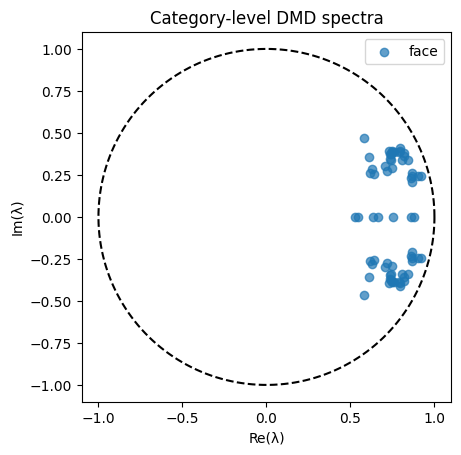

In [117]:
v = img_sets['all_faces']

X_cat = np.concatenate([X_centered[:, :, i] for i in v], axis=1)  # (units, time*images)
nodes = mrdmd(X_cat, max_levels=5)

theta = np.linspace(0, 2*np.pi, 400)
plt.plot(np.cos(theta), np.sin(theta), 'k--')

# for name, nodes in cat_nodes.items():
mu = np.concatenate([n.mu for n in nodes])
plt.scatter(mu.real, mu.imag, label='face', alpha=0.7)

plt.gca().set_aspect('equal'); plt.legend()
plt.xlabel('Re(λ)'); plt.ylabel('Im(λ)')
plt.title('Category-level DMD spectra')

/var/folders/nz/k0v468mj4w5_mx5nsmsgbwwc0000gq/T/ipykernel_87108/3436996048.py:78: RuntimeWarning: invalid value encountered in log
  slow = (np.abs(np.log(mu) / (2 * pi * step))) <= rho


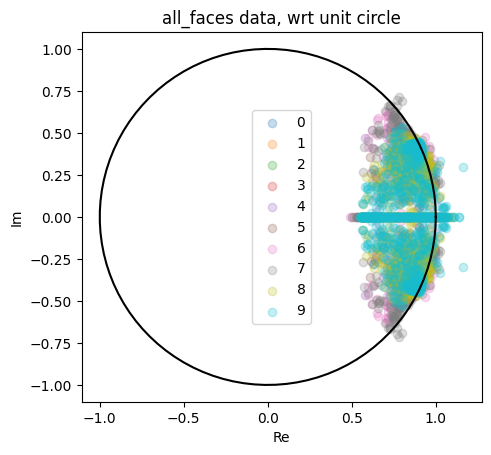

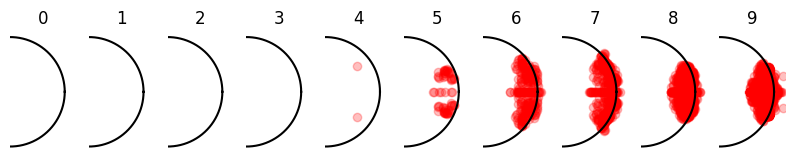

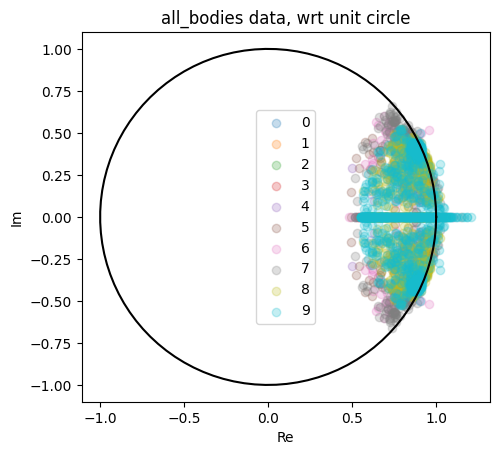

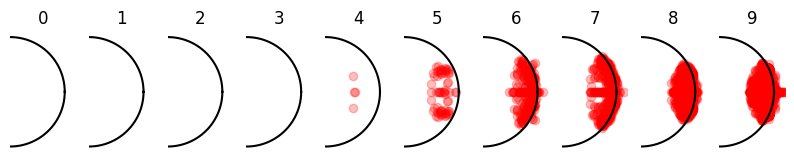

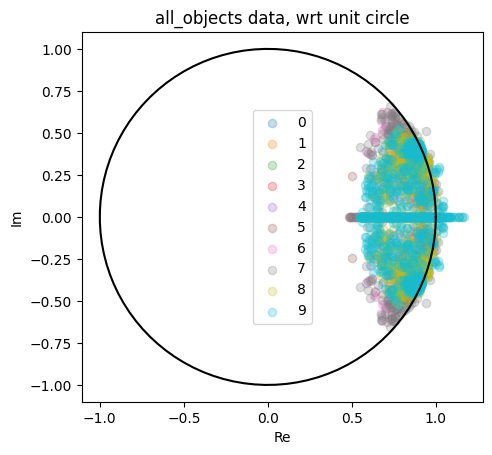

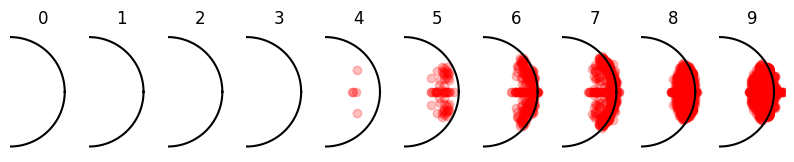

In [182]:
# D_cat: (units, T_cat) = time-concat of the 24 images in a category
# cuts: list of (start, stop) indices delimiting each image within D_cat
for k, v in img_sets.items():
    D_cat = np.concatenate([X_centered[:, :, i] for i in v], axis=1)  # (units, time*images)
    T = 450
    cuts = [(T*t, (1+t)*T) for t in range(24)]
    
    def mr_recon(D, max_levels=5):
        nodes = mrdmd(D, max_levels=max_levels)
        levels = sorted({nd.level for nd in nodes})
        Dhat = sum((lambda p: p[0] @ p[1])(stitch(nodes, l)) for l in levels)
        return Dhat.real, nodes
    
    # 1) category-shared fit and recon
    Dhat_cat, nodes_cat = mr_recon(D_cat, max_levels = 24*5)
    
    # 2) per-image fits and recons
    errs_cat, errs_indiv = [], []
    for (a,b) in cuts:
        Xi = D_cat[:, a:b]
        # per-image recon
        Xhat_indiv, _ = mr_recon(Xi)
    
        # slice the category recon to the same interval
        Xhat_cat = Dhat_cat[:, a:b]
    
        # fig,axes = plt.subplots(1,2)
        # ax = axes[0]
        # sns.heatmap(Xhat_indiv, cbar=False, ax=ax)
        # ax.set_axis_off()
        # ax = axes[1]
        # sns.heatmap(Xhat_cat, cbar=False, ax=ax)
        # ax.set_axis_off()
        # plt.show()
        
        # normalized Frobenius errors
        denom = np.linalg.norm(Xi)
        errs_indiv.append(np.linalg.norm(Xi - Xhat_indiv)/denom)
        errs_cat.append(  np.linalg.norm(Xi - Xhat_cat)/denom)
    
    # paired comparison (per image)
    errs_indiv = np.array(errs_indiv)
    errs_cat   = np.array(errs_cat)
    gap = errs_cat - errs_indiv  # >0 means category model worse

    fig,ax = plt.subplots(1,1)
    p = np.linspace(0, 2*np.pi, 100)
    ax.plot(np.cos(p), np.sin(p), c="k")
    
    levels = sorted({nd.level for nd in nodes_cat})
    for l in levels:
        ns = [n for n in nodes_cat if n.level == l]
        eigs = []
        for n in ns:
            eigs.extend(n.mu)
        eigs = np.array(eigs)
        ax.scatter(eigs.real, eigs.imag, alpha=0.25, label=l)
    
    ax.set_aspect("equal")
    ax.set_title(f'{k} data, wrt unit circle')
    ax.legend()
    # ax.set_xlim(left = 0)
    
    ax.set_xlabel('Re'); ax.set_ylabel('Im')
    
    fix,axes = plt.subplots(1,len(levels), figsize=(len(levels),len(levels)//2), sharey=True)
    # plot unit circle
    p = np.linspace(0, 2*np.pi, 100)
    
    for idx,l in enumerate(levels):
        ax = axes[idx]
        ax.plot(np.cos(p), np.sin(p), c="k")
        
        ns = [n for n in nodes_cat if n.level == l]
        eigs = []
        for n in ns:
            eigs.extend(n.mu)
        eigs = np.array(eigs)
        ax.scatter(eigs.real, eigs.imag, alpha=.25, c='red', label=l)
    
        ax.set_aspect("equal")
        ax.set_xlim(left = 0, right=1.2)
        ax.set_title(f'{l}')
        ax.set_axis_off()

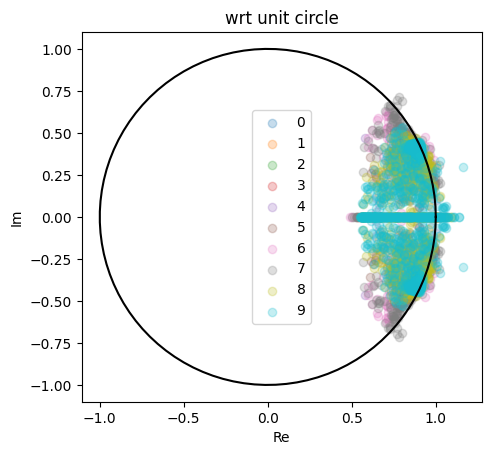

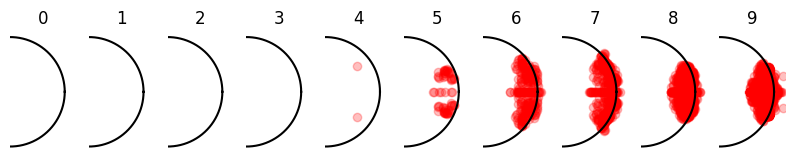

In [177]:
fig,ax = plt.subplots(1,1)
p = np.linspace(0, 2*np.pi, 100)
ax.plot(np.cos(p), np.sin(p), c="k")

levels = sorted({nd.level for nd in nodes_cat})
for l in levels:
    ns = [n for n in nodes_cat if n.level == l]
    eigs = []
    for n in ns:
        eigs.extend(n.mu)
    eigs = np.array(eigs)
    ax.scatter(eigs.real, eigs.imag, alpha=0.25, label=l)

ax.set_aspect("equal")
ax.set_title('wrt unit circle')
ax.legend()
# ax.set_xlim(left = 0)

ax.set_xlabel('Re'); ax.set_ylabel('Im')

fix,axes = plt.subplots(1,len(levels), figsize=(len(levels),len(levels)//2), sharey=True)
# plot unit circle
p = np.linspace(0, 2*np.pi, 100)

for idx,l in enumerate(levels):
    ax = axes[idx]
    ax.plot(np.cos(p), np.sin(p), c="k")
    
    ns = [n for n in nodes_cat if n.level == l]
    eigs = []
    for n in ns:
        eigs.extend(n.mu)
    eigs = np.array(eigs)
    ax.scatter(eigs.real, eigs.imag, alpha=.25, c='red', label=l)

    ax.set_aspect("equal")
    ax.set_xlim(left = 0, right=1.2)
    ax.set_title(f'{l}')
    ax.set_axis_off()

In [179]:
levels = sorted({nd.level for nd in nodes_cat})
out = []
for l in levels:
    bin_sizes = [nd.bin_size for nd in nodes_cat if nd.level==l]
    # they’re equal within level if you split evenly:
    B = max(bin_sizes)
    fmax = (nodes_cat[0].rho * B) / (nodes_cat[0].step * nodes_cat[0].bin_size)  # or simply max_cycles/(B*dt)
    # use the definition you used for rho; simplest:
    # fmax = max_cycles / (B * dt)
    out.append((l, B, B*dt, fmax))
out

[(0, 10800, 10800, 2.7434842249657064e-07),
 (1, 5400, 5400, 1.3717421124828532e-07),
 (2, 2700, 2700, 6.858710562414266e-08),
 (3, 1350, 1350, 3.429355281207133e-08),
 (4, 675, 675, 1.7146776406035665e-08),
 (5, 338, 338, 8.586089518874154e-09),
 (6, 169, 169, 4.293044759437077e-09),
 (7, 85, 85, 2.1592236955748615e-09),
 (8, 43, 43, 1.0923131636437535e-09),
 (9, 22, 22, 5.588578976781994e-10)]

In [176]:
levels

[0, 1, 2, 3, 4, 5]